In [1]:
import warnings
warnings.filterwarnings('ignore')

from cplex import Cplex

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from itertools import product

In [2]:
# initialize MILP solver
solver = Cplex()

# effort level for finding multiple optima - 4 indicates maximum effort to find multiple optima
solver.parameters.mip.pool.intensity.set(4)

# absolute tolerance gap for solution pool - solutions in the pool must be at most 0.000001 units apart - did not set to 0.0 due to Python float rounding errors
solver.parameters.mip.pool.absgap.set(0.000001)

# suppress solver outputs
solver.parameters.mip.display.set(0)
solver.set_results_stream(None)

In [3]:
scip_counts = pd.read_csv('scip_counts.csv').drop(columns = 'Most recent MIPLIB version')

scip_counts = scip_counts[scip_counts.iloc[:, 1].str.isdigit()]

scip_counts['Number of distinct optima (SCIP)'] = scip_counts['Number of distinct optima (SCIP)'].astype(int)

scip_counts

,MIPLIB instance,Number of distinct optima (SCIP)
0,set1al,2
1,set1cl,2
2,p0201,4
3,bell3a,5
4,mod008,6
5,p0033,9
6,lp4l,24
7,vpm2,33
8,khb05250,51
9,stein9,54


In [4]:
def count_optima(instance_filepath, solver, poplim, seed):

    # set random seed for solver
    solver.parameters.randomseed.set(seed)

    # set maximum number of solutions in solution pool to poplim argument
    solver.parameters.mip.limits.populate.set(poplim)

    # read in mps file
    solver.read(instance_filepath)

    # get start time before solving for all optima
    start = solver.get_time()

    # solve for all optima
    solver.populate_solution_pool()

    # get end time after solving for all optima
    end = solver.get_time()

    # calculate runtime by subtracting start time from end time
    runtime = end - start

    # count the number of optima in the solution pool
    count = solver.solution.pool.get_num()

    return count, runtime

In [5]:
optima_counts = dict(zip(scip_counts.iloc[:, 0], scip_counts.iloc[:, 1]))
scalars = 2 ** np.arange(10)

In [6]:
instances = []
counts = []
runtimes = []
poplims = []

for seed, ((instance, num_optima), poplim_scalar) in enumerate(product(optima_counts.items(), scalars), 1):

    poplim = poplim_scalar * num_optima

    num_optima, runtime = count_optima(instance_filepath = f'../../mps_files/{instance}.mps',
                                       solver = solver,
                                       poplim = int(poplim),
                                       seed = seed)

    instances.append(instance)
    counts.append(num_optima)
    runtimes.append(runtime)
    poplims.append(poplim)

In [7]:
results = pd.DataFrame(
    {'MIPLIB instance': instances,
     'POPLIM setting': poplims,
     'CPLEX runtime (seconds)': runtimes,
     'Number of distinct optima (CPLEX)': counts}
)

results = results.merge(scip_counts, 
                        how = 'inner',
                        on = 'MIPLIB instance')

# subtract number of optima enumerated with CPLEX from number of optima enumerated with SCIP
results['Number of missed optima'] = results.apply(lambda x: int(x['Number of distinct optima (SCIP)']) - x['Number of distinct optima (CPLEX)'],
                                                   axis = 1)

results.sort_values(by = ['MIPLIB instance', 'POPLIM setting'],
                    inplace = True)

results.insert(2, 'POPLIM ratio', [2 ** x for x in range(10)] * len(set(instances)))

results.sample(10, random_state = 1)

,MIPLIB instance,POPLIM setting,POPLIM ratio,CPLEX runtime (seconds),Number of distinct optima (CPLEX),Number of distinct optima (SCIP),Number of missed optima
84,khb05250,816,16,1.027116,1,51,50
148,stein27,539136,256,1.308378,2106,2106,0
15,set1cl,64,32,0.354933,2,2,0
86,khb05250,3264,64,0.775140,1,51,50
121,supportcase16,512,2,0.298079,256,256,0
26,p0201,256,64,0.605997,4,4,0
71,vpm2,66,2,2.623263,33,33,0
54,p0033,144,16,0.074783,9,9,0
69,lp4l,12288,512,0.590263,24,24,0
110,supportcase14,256,1,0.750001,256,256,0


#### For 3 instances, CPLEX fails to find all optima

In [8]:
results[results['Number of missed optima'] != 0]

,MIPLIB instance,POPLIM setting,POPLIM ratio,CPLEX runtime (seconds),Number of distinct optima (CPLEX),Number of distinct optima (SCIP),Number of missed optima
80,khb05250,51,1,0.836933,1,51,50
81,khb05250,102,2,0.657332,1,51,50
82,khb05250,204,4,0.436385,1,51,50
83,khb05250,408,8,0.573093,1,51,50
84,khb05250,816,16,1.027116,1,51,50
85,khb05250,1632,32,0.863909,1,51,50
86,khb05250,3264,64,0.775140,1,51,50
87,khb05250,6528,128,0.819597,1,51,50
88,khb05250,13056,256,0.345330,1,51,50
89,khb05250,26112,512,0.420214,1,51,50


#### Runtime vs. POPLIM ratio (POPLIM setting divided by number of optima)

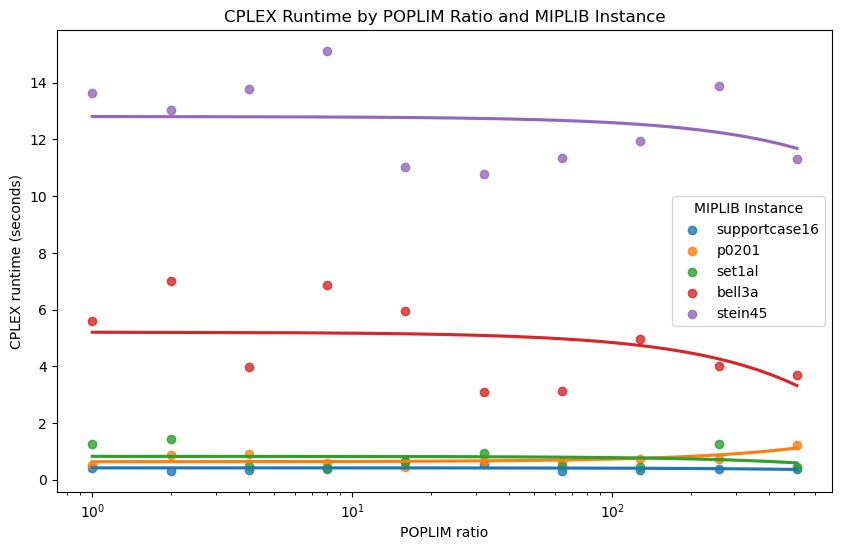

In [9]:
plt.figure(figsize = (10, 6))

for instance, color in zip(np.random.choice(results['MIPLIB instance'].unique(), 5, replace = False), ['red', 'orange', 'green', 'blue', 'purple']):
    ax = sns.regplot(x = 'POPLIM ratio',
                     y = 'CPLEX runtime (seconds)',
                     ci = False,
                     label = instance,
                     data = results[results['MIPLIB instance'] == instance])

ax.legend(title = 'MIPLIB Instance')

plt.title('CPLEX Runtime by POPLIM Ratio and MIPLIB Instance')

plt.xscale('log')

plt.show()

In [10]:
# write results to csv file
results.to_csv('results_poplim.csv', index = False)